# Soil Structural Data Comparison

This notebook simply compares several different sets of soil structural data, clarifying how they can be used and noting their imperfections.

To run an integrated hydrology simulation, we need at least:

* porosity
* permeability
* van Genuchten or other WRM, typically generated from Rosetta from texture data + bulk density
* soil structural model (e.g. formations + horizons or other layering strategy)

For a structural model, we typically define two or three layers:  bedrock, a geologic layer, and (sometimes) a soil layer.  For the horizontal component, it is most convenient to work with formations -- horizontal shapes whose bodies are assumed to be homogeneous within the shape and layer.  We can work with fields of porosity and permeability, but currently ATS does not support fields of van Genuchten parameters, and running Rosetta at every pixel seems excessive anyway.  So we prefer to avoid doing that.


In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import shapely

import workflow
import workflow.plot
import workflow.crs
import workflow.ui
import workflow.condition

from workflow.sources.manager_nhd import FileManagerNHDPlus
from workflow.sources.manager_glhymps import FileManagerGLHYMPS
from workflow.sources.manager_soilgrids_2017 import FileManagerSoilGrids2017
from workflow.sources.manager_nrcs import FileManagerNRCS


In [3]:
workflow.ui.setup_logging(1)
import fiona
print(fiona.__version__)

1.8.18


In [4]:
# user input -- choose the HUC to work on
#huc = '14020001'
huc = '140200010204'
crs = workflow.crs.default_crs()

In [5]:
# collect the HUC from NHDPlus
_, watershed = workflow.get_huc(FileManagerNHDPlus(), huc, crs)
print(watershed.bounds)

2021-06-04 14:30:44,083 - root - INFO: 
2021-06-04 14:30:44,085 - root - INFO: Loading HUC 140200010204
2021-06-04 14:30:44,086 - root - INFO: ------------------------------
2021-06-04 14:30:44,087 - root - INFO: 
2021-06-04 14:30:44,088 - root - INFO: Loading level 12 HUCs in 140200010204
2021-06-04 14:30:44,089 - root - INFO: ------------------------------
2021-06-04 14:30:44,091 - root - INFO: Using HUC file "/Users/uec/code/watershed_workflow/data-library/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb"
2021-06-04 14:30:44,196 - root - INFO: ... found 1 HUCs
2021-06-04 14:30:44,196 - root - INFO:   -- 140200010204
2021-06-04 14:30:44,207 - root - INFO: Converting to out_crs
2021-06-04 14:30:44,240 - root - INFO: Converting to shapely
2021-06-04 14:30:44,242 - root - INFO: ... found 1


(-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)


/Users/Shared/ornldev/code/miniconda3/envs/watershed_workflow_20210603/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


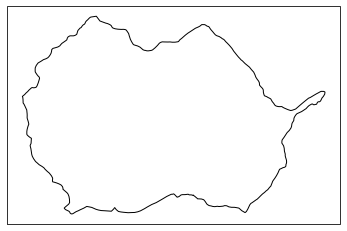

In [6]:
# plot what we have so far -- an image of the HUC
fig, ax = workflow.plot.get_ax(crs)
workflow.plot.shply(watershed, crs, ax=ax, color='k', linewidth=1)

## Available Products

The following products are routinely available across the US (or globally).

### GLHYMPS

The Global Hydrogeology Maps product provides data by shapefile/formation, and provides:

* porosity
* permeability
* depth-to-bedrock

This dataset is fairly complete, but there are some oddities -- most notably much of the DTB field seems to be 0, and a significant subset of the porosity are 0 (mostly clays, we threshold at 1% to avoid this).  But the data is pretty good and complete.  However, it is missing WRM parameters (or equivalently, texture information).

In [7]:
# first let's look at GLYHMPS
# -- get the data
gl = FileManagerGLHYMPS()
gl_crs, gl_shps, gl_props = workflow.get_shapes(gl, watershed.bounds, crs, crs, properties=True)

gl_props.set_index('id', inplace=True, drop=False)
gl_ids = np.array([shp.properties['id'] for shp in gl_shps], np.int32)
print(gl_ids)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
gl_color_raster, gl_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(watershed.bounds, 10, gl_shps,
                                              gl_ids, crs)

# -- print extent of properties
gl_logK = np.log10(gl_props['permeability [m^2]'][:])
print('logK', gl_logK.min(), gl_logK.max())

poro = gl_props['porosity [-]']
print('poro', poro.min(), poro.max())

dtb = gl_props['depth to bedrock [m]']
print('dtb', dtb.min(), dtb.max())


2021-06-04 14:30:46,975 - root - INFO: 
2021-06-04 14:30:46,977 - root - INFO: Loading shapes
2021-06-04 14:30:46,978 - root - INFO: ------------------------------
2021-06-04 14:30:46,979 - root - INFO: Getting shapes of GLHYMPS on bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:30:46,980 - root - INFO:   from file: /Users/uec/code/watershed_workflow/data-library/soil_structure/GLHYMPS/GLHYMPS.shp
2021-06-04 14:30:47,095 - fiona.ogrext - INFO: Failed to auto identify EPSG: 7
/Users/uec/code/watershed_workflow/repos/master/workflow/sources/manager_shape.py:76: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  shps = [s for (i,s) in fid.items(bbox=bounds)]
2021-06-04 14:30:51,666 - root - INFO: ... found 19 shapes
2021-06-04 14:30:51,666 - root - INFO: Converting to shapely
2021-06-04 14:30:51,686 - root - INFO: Converting to requested CRS
2021-06-04 14:30:51,

[715383 715639 715707 715766 715779 715796 715833 726508 726604 726608
 726639 726642 726650 726664 726667 726671 726678 726681 730801]
logK -15.2 -10.52
poro 0.01 0.22
dtb 0.0 20.0365447154


Text(0.5, 1.0, 'GLHMPS')

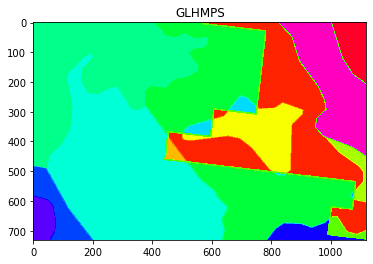

In [8]:
# plot the formations
plt.figure()
unique_inds, gl_cmap, gl_norm, gl_ticks, gl_labels = workflow.colors.generate_indexed_colormap(gl_ids)


plt.imshow(gl_color_raster, cmap=gl_cmap, norm=gl_norm)
plt.title("GLHMPS")

In [9]:
# generate glhymps porosity, permeability fields
# -- create a profile
gl_profile = gl_color_profile.copy()
gl_profile['nodata'] = np.nan
gl_profile['dtype'] = 'double'

# -- porosity
gl_poro = np.nan * np.ones_like(gl_color_raster)
for str_id in gl_props.index:
    gl_poro[gl_color_raster == str_id] = gl_props.loc[str_id,'porosity [-]']
    
# -- permeability
gl_perm = np.nan * np.ones_like(gl_color_raster)
for str_id in gl_props.index:
    gl_perm[gl_color_raster == str_id] = gl_props.loc[str_id,'permeability [m^2]']


2021-06-04 14:30:52,131 - root - INFO: BOUNDS: (-952556.0, 1811081.0, -941366.0, 1818391.0)
2021-06-04 14:30:52,263 - root - INFO: BOUNDS: (-952556.0, 1811081.0, -941366.0, 1818391.0)


Text(0.5, 1.0, 'log permeability [m^2]')

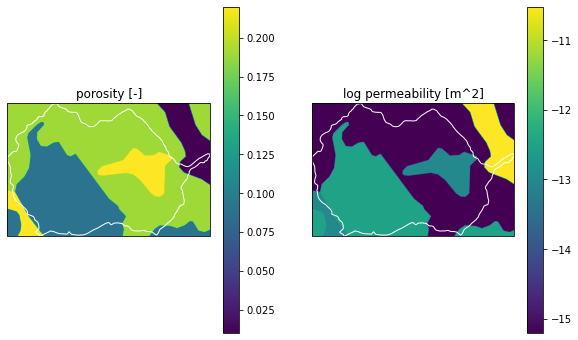

In [10]:
# plot porosity and perm for glhymps
fig, ax = workflow.plot.get_ax(crs, nrow=1, ncol=2, index=1, figsize=(10,6))
cb = workflow.plot.raster(gl_profile, gl_poro, ax)
workflow.plot.shply(watershed, crs, 'w', ax)
fig.colorbar(cb, ax=ax)
ax.set_title('porosity [-]')

ax = workflow.plot.get_ax(crs, fig=fig, nrow=1, ncol=2, index=2)
cb = workflow.plot.raster(gl_profile, np.log10(gl_perm), ax)
workflow.plot.shply(watershed, crs, 'w', ax)
fig.colorbar(cb, ax=ax)
ax.set_title('log permeability [m^2]')

### SoilGrids (2017)

SoilGrids is a great product -- 250m, global rasters of:

* depth to bedrock
* bulk density
* texture via percent sand/silt/clay
* and more...

Effectively everything is available that is needed to run Rosetta to get a full suite of parameters.  Vertically, bulk density and texture information are provided at 7 layers, the deepest starting at 2m.  Data is complete globally, and doesn't seem to have much missing data except under water bodies.  The only downside is the raster nature of the data -- to use this directly we would have to run every pixel through Rosetta and provide fields of Van Genuchten parameters.  We could conceivably use the rasters of porosity and permeability, but it seems more convenient to work by formation instead of as a raster.

Note that here we use the 2017 product instead of the 2020 product as that has yet to include depth-to-bedrock.

In [11]:
# SoilGrids
sg = FileManagerSoilGrids2017('US')
sg_profile, sg_raster = workflow.get_raster_on_shape(sg, watershed, crs, crs, mask=True, 
                                                     nodata=-1, variable='BDTICM')

# for some reason soilgrid's nodata doesn't match the actual value in the raster?
print(sg_raster.min())
print(sg_profile['nodata'])
sg_profile['nodata'] = sg_raster.min()

# note we have two nodata values now, the one from the fill value outside of the watershed (-1) 
# and the one from the missing gaps (sg_profile['nodata'])
print(sg_raster)

2021-06-04 14:30:56,883 - root - INFO: 
2021-06-04 14:30:56,885 - root - INFO: Loading Raster
2021-06-04 14:30:56,887 - root - INFO: ------------------------------
2021-06-04 14:30:56,889 - root - INFO: Collecting raster
2021-06-04 14:30:56,896 - root - INFO: CRS: EPSG:4326
2021-06-04 14:30:56,897 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/BDTICM_M_250m_ll_us.tif
2021-06-04 14:30:56,981 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:30:56,982 - root - INFO: Warping to out_crs
2021-06-04 14:30:57,068 - root - INFO: Masking to shape
2021-06-04 14:30:57,070 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:30:57,073 - root - INFO:   casting mask of dtype: int32 to: -1
2021-06-04 14:30:57,074 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)


bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
-1
-32768
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


SoilGrids has holes where there is standing water, but we still need soil in these places.  Fill these using a nearest neighbor algorithm.

2021-06-04 14:30:58,537 - root - INFO: BOUNDS: (-953207.4247614401, 1809926.1760029723, -941104.09728237, 1818955.642534977)
2021-06-04 14:30:58,675 - root - INFO: BOUNDS: (-953207.4247614401, 1809926.1760029723, -941104.09728237, 1818955.642534977)


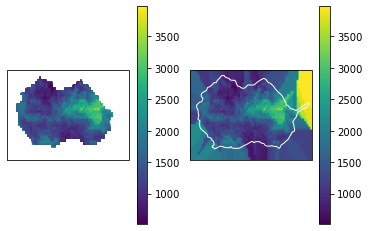

In [12]:
# plot SoilGrids DTB
# -- get a temp raster to make external (-1) and nodata the same color
sg_raster2 = sg_raster.copy()
sg_raster2[sg_raster == -1] = sg_profile['nodata']

fig, ax = workflow.plot.get_ax(crs, nrow=1, ncol=2, index=1)
cb = workflow.plot.raster(sg_profile, sg_raster2, ax)
workflow.plot.shply(watershed, crs, 'w', ax)
fig.colorbar(cb, ax=ax)

sg_raster2 = workflow.condition.fill_gaps(sg_raster, nodata=sg_profile['nodata'])

sg_profile['nodata'] = -1
ax = workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
cb = workflow.plot.raster(sg_profile, sg_raster2, ax)
workflow.plot.shply(watershed, crs, 'w', ax)
fig.colorbar(cb, ax=ax)


2021-06-04 14:30:58,831 - root - INFO: 
2021-06-04 14:30:58,832 - root - INFO: Loading Raster
2021-06-04 14:30:58,833 - root - INFO: ------------------------------
2021-06-04 14:30:58,834 - root - INFO: Collecting raster
2021-06-04 14:30:58,837 - root - INFO: CRS: EPSG:4326
2021-06-04 14:30:58,837 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/BLDFIE_M_sl7_250m_ll_us.tif
2021-06-04 14:30:58,911 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:30:58,911 - root - INFO: Warping to out_crs
2021-06-04 14:30:58,979 - root - INFO: Masking to shape
2021-06-04 14:30:58,980 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:30:58,982 - root - INFO:   casting mask of dtype: int16 to: -1
2021-06-04 14:30:58,983 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:30:58,987 - root

bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
-32768 -1 1676
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)


2021-06-04 14:30:59,126 - root - INFO: Masking to shape
2021-06-04 14:30:59,128 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:30:59,130 - root - INFO:   casting mask of dtype: uint8 to: 254
2021-06-04 14:30:59,131 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:30:59,135 - root - INFO: 
2021-06-04 14:30:59,137 - root - INFO: Loading Raster
2021-06-04 14:30:59,137 - root - INFO: ------------------------------
2021-06-04 14:30:59,138 - root - INFO: Collecting raster
2021-06-04 14:30:59,141 - root - INFO: CRS: EPSG:4326
2021-06-04 14:30:59,142 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/SLTPPT_M_sl7_250m_ll_us.tif
2021-06-04 14:30:59,215 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:30:59,215 - root - INFO: Warping to out_crs
2021-06-04 14:30:59,279 - roo

255
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
255


2021-06-04 14:30:59,365 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:30:59,366 - root - INFO: Warping to out_crs
2021-06-04 14:30:59,429 - root - INFO: Masking to shape
2021-06-04 14:30:59,431 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:30:59,432 - root - INFO:   casting mask of dtype: uint8 to: 254
2021-06-04 14:30:59,433 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)


bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
255


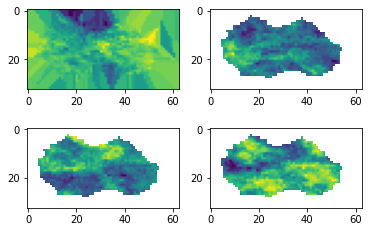

In [13]:
# now try clustering the soilgrids data
cluster_input = np.empty(sg_raster.shape+(4,), 'd')

fig = plt.figure()

# bulk density
profile, raster = workflow.get_raster_on_shape(sg, watershed, crs, crs, mask=True, 
                                            nodata=-1, variable='BLDFIE', layer=7)
print(profile['nodata'], raster.min(), raster.max())
profile['nodata'] = raster.min()
cluster_input[:,:,0] = np.where(raster == profile['nodata'], np.nan, raster)
cluster_input[:,:,0] = workflow.condition.fill_gaps(cluster_input[:,:,0])
cluster_input[:,:,0] = np.where(cluster_input[:,:,0] == -1, np.nan, cluster_input[:,:,0])

# texture
for i, varname in enumerate(['CLYPPT', 'SLTPPT', 'SNDPPT']):
    profile, raster = workflow.get_raster_on_shape(sg, watershed, crs, crs, mask=True, 
                                                   nodata=254, variable=varname, layer=7)
    print(profile['nodata'])
    assert(profile['nodata'] == 255)
    cluster_input[:,:,i+1] = np.where(raster == profile['nodata'], np.nan, raster)
    cluster_input[:,:,i+1] = workflow.condition.fill_gaps(cluster_input[:,:,i+1])
    cluster_input[:,:,i+1] = np.where(cluster_input[:,:,i+1] == 254, np.nan, cluster_input[:,:,i+1])


for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(cluster_input[:,:,i])


In [14]:
# do the clustering
for i in range(4,10):
    plt.figure()
    codebook, codes, err = workflow.soil_properties.cluster(cluster_input, i+1)
    print(err[0], np.median(err[1]))
    plt.imshow(codes)
    plt.title(f'clusters = {i+1}, error = {np.median(err[1])}')
    

ValueError: array must not contain infs or NaNs

<Figure size 432x288 with 0 Axes>

2021-06-04 14:31:02,692 - root - INFO: 
2021-06-04 14:31:02,694 - root - INFO: Loading Raster
2021-06-04 14:31:02,695 - root - INFO: ------------------------------
2021-06-04 14:31:02,696 - root - INFO: Collecting raster
2021-06-04 14:31:02,702 - root - INFO: CRS: EPSG:4326
2021-06-04 14:31:02,703 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/BLDFIE_M_sl1_250m_ll_us.tif
2021-06-04 14:31:02,784 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:02,785 - root - INFO: Warping to out_crs
2021-06-04 14:31:02,850 - root - INFO: Masking to shape
2021-06-04 14:31:02,852 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:02,854 - root - INFO:   casting mask of dtype: int16 to: -1
2021-06-04 14:31:02,855 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:31:02,859 - root

bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
-32768 -1 1194
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)


2021-06-04 14:31:03,003 - root - INFO: Masking to shape
2021-06-04 14:31:03,005 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:03,007 - root - INFO:   casting mask of dtype: uint8 to: 254
2021-06-04 14:31:03,008 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:31:03,012 - root - INFO: 
2021-06-04 14:31:03,012 - root - INFO: Loading Raster
2021-06-04 14:31:03,013 - root - INFO: ------------------------------
2021-06-04 14:31:03,013 - root - INFO: Collecting raster
2021-06-04 14:31:03,017 - root - INFO: CRS: EPSG:4326
2021-06-04 14:31:03,018 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/SLTPPT_M_sl1_250m_ll_us.tif
2021-06-04 14:31:03,089 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:03,090 - root - INFO: Warping to out_crs
2021-06-04 14:31:03,153 - roo

255
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
255


2021-06-04 14:31:03,239 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:03,240 - root - INFO: Warping to out_crs
2021-06-04 14:31:03,302 - root - INFO: Masking to shape
2021-06-04 14:31:03,303 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:03,305 - root - INFO:   casting mask of dtype: uint8 to: 254
2021-06-04 14:31:03,306 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:31:03,311 - root - INFO: 
2021-06-04 14:31:03,312 - root - INFO: Loading Raster
2021-06-04 14:31:03,312 - root - INFO: ------------------------------
2021-06-04 14:31:03,313 - root - INFO: Collecting raster
2021-06-04 14:31:03,317 - root - INFO: CRS: EPSG:4326
2021-06-04 14:31:03,318 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/BLDFIE_M_sl2_250m_ll_us.tif
2021-06-04 14:31:03,393 - roo

bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
255
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)


2021-06-04 14:31:03,458 - root - INFO: Masking to shape
2021-06-04 14:31:03,459 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:03,461 - root - INFO:   casting mask of dtype: int16 to: -1
2021-06-04 14:31:03,462 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:31:03,466 - root - INFO: 
2021-06-04 14:31:03,467 - root - INFO: Loading Raster
2021-06-04 14:31:03,467 - root - INFO: ------------------------------
2021-06-04 14:31:03,468 - root - INFO: Collecting raster
2021-06-04 14:31:03,472 - root - INFO: CRS: EPSG:4326
2021-06-04 14:31:03,472 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/CLYPPT_M_sl2_250m_ll_us.tif
2021-06-04 14:31:03,553 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:03,554 - root - INFO: Warping to out_crs
2021-06-04 14:31:03,623 - root

-32768 -1 1204
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
255


2021-06-04 14:31:03,709 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:03,710 - root - INFO: Warping to out_crs
2021-06-04 14:31:03,773 - root - INFO: Masking to shape
2021-06-04 14:31:03,774 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:03,776 - root - INFO:   casting mask of dtype: uint8 to: 254
2021-06-04 14:31:03,777 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:31:03,781 - root - INFO: 
2021-06-04 14:31:03,781 - root - INFO: Loading Raster
2021-06-04 14:31:03,782 - root - INFO: ------------------------------
2021-06-04 14:31:03,782 - root - INFO: Collecting raster
2021-06-04 14:31:03,787 - root - INFO: CRS: EPSG:4326
2021-06-04 14:31:03,788 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/SNDPPT_M_sl2_250m_ll_us.tif
2021-06-04 14:31:03,862 - roo

bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
255
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)


2021-06-04 14:31:03,928 - root - INFO: Masking to shape
2021-06-04 14:31:03,929 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:03,931 - root - INFO:   casting mask of dtype: uint8 to: 254
2021-06-04 14:31:03,932 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:31:03,937 - root - INFO: 
2021-06-04 14:31:03,938 - root - INFO: Loading Raster
2021-06-04 14:31:03,938 - root - INFO: ------------------------------
2021-06-04 14:31:03,939 - root - INFO: Collecting raster
2021-06-04 14:31:03,944 - root - INFO: CRS: EPSG:4326
2021-06-04 14:31:03,944 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/BLDFIE_M_sl3_250m_ll_us.tif
2021-06-04 14:31:04,022 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:04,023 - root - INFO: Warping to out_crs
2021-06-04 14:31:04,085 - roo

255
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
-32768 -1 1364


2021-06-04 14:31:04,168 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:04,169 - root - INFO: Warping to out_crs
2021-06-04 14:31:04,230 - root - INFO: Masking to shape
2021-06-04 14:31:04,231 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:04,233 - root - INFO:   casting mask of dtype: uint8 to: 254
2021-06-04 14:31:04,233 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:31:04,238 - root - INFO: 
2021-06-04 14:31:04,238 - root - INFO: Loading Raster
2021-06-04 14:31:04,239 - root - INFO: ------------------------------
2021-06-04 14:31:04,239 - root - INFO: Collecting raster
2021-06-04 14:31:04,244 - root - INFO: CRS: EPSG:4326
2021-06-04 14:31:04,244 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/SLTPPT_M_sl3_250m_ll_us.tif
2021-06-04 14:31:04,315 - roo

bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
255
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)


2021-06-04 14:31:04,391 - root - INFO: Masking to shape
2021-06-04 14:31:04,393 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:04,395 - root - INFO:   casting mask of dtype: uint8 to: 254
2021-06-04 14:31:04,396 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:31:04,400 - root - INFO: 
2021-06-04 14:31:04,401 - root - INFO: Loading Raster
2021-06-04 14:31:04,402 - root - INFO: ------------------------------
2021-06-04 14:31:04,403 - root - INFO: Collecting raster
2021-06-04 14:31:04,407 - root - INFO: CRS: EPSG:4326
2021-06-04 14:31:04,407 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/SNDPPT_M_sl3_250m_ll_us.tif
2021-06-04 14:31:04,484 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:04,485 - root - INFO: Warping to out_crs
2021-06-04 14:31:04,552 - roo

255
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
255


2021-06-04 14:31:04,641 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:04,642 - root - INFO: Warping to out_crs
2021-06-04 14:31:04,709 - root - INFO: Masking to shape
2021-06-04 14:31:04,710 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:04,712 - root - INFO:   casting mask of dtype: int16 to: -1
2021-06-04 14:31:04,713 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:31:04,718 - root - INFO: 
2021-06-04 14:31:04,718 - root - INFO: Loading Raster
2021-06-04 14:31:04,719 - root - INFO: ------------------------------
2021-06-04 14:31:04,719 - root - INFO: Collecting raster
2021-06-04 14:31:04,723 - root - INFO: CRS: EPSG:4326
2021-06-04 14:31:04,724 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/CLYPPT_M_sl4_250m_ll_us.tif
2021-06-04 14:31:04,794 - root

bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
-32768 -1 1450
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)


2021-06-04 14:31:04,855 - root - INFO: Masking to shape
2021-06-04 14:31:04,857 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:04,858 - root - INFO:   casting mask of dtype: uint8 to: 254
2021-06-04 14:31:04,859 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:31:04,863 - root - INFO: 
2021-06-04 14:31:04,864 - root - INFO: Loading Raster
2021-06-04 14:31:04,864 - root - INFO: ------------------------------
2021-06-04 14:31:04,865 - root - INFO: Collecting raster
2021-06-04 14:31:04,869 - root - INFO: CRS: EPSG:4326
2021-06-04 14:31:04,870 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/SLTPPT_M_sl4_250m_ll_us.tif
2021-06-04 14:31:04,945 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:04,945 - root - INFO: Warping to out_crs
2021-06-04 14:31:05,015 - roo

255
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
255


2021-06-04 14:31:05,107 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:05,108 - root - INFO: Warping to out_crs
2021-06-04 14:31:05,179 - root - INFO: Masking to shape
2021-06-04 14:31:05,180 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:05,182 - root - INFO:   casting mask of dtype: uint8 to: 254
2021-06-04 14:31:05,183 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:31:05,188 - root - INFO: 
2021-06-04 14:31:05,189 - root - INFO: Loading Raster
2021-06-04 14:31:05,189 - root - INFO: ------------------------------
2021-06-04 14:31:05,190 - root - INFO: Collecting raster
2021-06-04 14:31:05,196 - root - INFO: CRS: EPSG:4326
2021-06-04 14:31:05,197 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/BLDFIE_M_sl5_250m_ll_us.tif
2021-06-04 14:31:05,277 - roo

bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
255
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)


2021-06-04 14:31:05,339 - root - INFO: Masking to shape
2021-06-04 14:31:05,340 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:05,342 - root - INFO:   casting mask of dtype: int16 to: -1
2021-06-04 14:31:05,343 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:31:05,347 - root - INFO: 
2021-06-04 14:31:05,348 - root - INFO: Loading Raster
2021-06-04 14:31:05,348 - root - INFO: ------------------------------
2021-06-04 14:31:05,349 - root - INFO: Collecting raster
2021-06-04 14:31:05,352 - root - INFO: CRS: EPSG:4326
2021-06-04 14:31:05,353 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/CLYPPT_M_sl5_250m_ll_us.tif
2021-06-04 14:31:05,429 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:05,430 - root - INFO: Warping to out_crs
2021-06-04 14:31:05,497 - root

-32768 -1 1565
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
255


2021-06-04 14:31:05,581 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:05,582 - root - INFO: Warping to out_crs
2021-06-04 14:31:05,645 - root - INFO: Masking to shape
2021-06-04 14:31:05,646 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:05,648 - root - INFO:   casting mask of dtype: uint8 to: 254
2021-06-04 14:31:05,649 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:31:05,653 - root - INFO: 
2021-06-04 14:31:05,653 - root - INFO: Loading Raster
2021-06-04 14:31:05,654 - root - INFO: ------------------------------
2021-06-04 14:31:05,654 - root - INFO: Collecting raster
2021-06-04 14:31:05,659 - root - INFO: CRS: EPSG:4326
2021-06-04 14:31:05,659 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/SNDPPT_M_sl5_250m_ll_us.tif
2021-06-04 14:31:05,730 - roo

bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
255
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)


2021-06-04 14:31:05,799 - root - INFO: Masking to shape
2021-06-04 14:31:05,800 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:05,802 - root - INFO:   casting mask of dtype: uint8 to: 254
2021-06-04 14:31:05,803 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:31:05,807 - root - INFO: 
2021-06-04 14:31:05,808 - root - INFO: Loading Raster
2021-06-04 14:31:05,809 - root - INFO: ------------------------------
2021-06-04 14:31:05,809 - root - INFO: Collecting raster
2021-06-04 14:31:05,814 - root - INFO: CRS: EPSG:4326
2021-06-04 14:31:05,815 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/BLDFIE_M_sl6_250m_ll_us.tif
2021-06-04 14:31:05,892 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:05,892 - root - INFO: Warping to out_crs
2021-06-04 14:31:05,955 - roo

255
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
-32768 -1 1655


2021-06-04 14:31:06,041 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:06,042 - root - INFO: Warping to out_crs
2021-06-04 14:31:06,112 - root - INFO: Masking to shape
2021-06-04 14:31:06,113 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:06,115 - root - INFO:   casting mask of dtype: uint8 to: 254
2021-06-04 14:31:06,116 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:31:06,121 - root - INFO: 
2021-06-04 14:31:06,121 - root - INFO: Loading Raster
2021-06-04 14:31:06,122 - root - INFO: ------------------------------
2021-06-04 14:31:06,123 - root - INFO: Collecting raster
2021-06-04 14:31:06,127 - root - INFO: CRS: EPSG:4326
2021-06-04 14:31:06,128 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/SLTPPT_M_sl6_250m_ll_us.tif
2021-06-04 14:31:06,200 - roo

bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
255
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)


2021-06-04 14:31:06,265 - root - INFO: Masking to shape
2021-06-04 14:31:06,266 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:06,267 - root - INFO:   casting mask of dtype: uint8 to: 254
2021-06-04 14:31:06,268 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:31:06,272 - root - INFO: 
2021-06-04 14:31:06,273 - root - INFO: Loading Raster
2021-06-04 14:31:06,273 - root - INFO: ------------------------------
2021-06-04 14:31:06,274 - root - INFO: Collecting raster
2021-06-04 14:31:06,278 - root - INFO: CRS: EPSG:4326
2021-06-04 14:31:06,278 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/SNDPPT_M_sl6_250m_ll_us.tif
2021-06-04 14:31:06,359 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:06,360 - root - INFO: Warping to out_crs
2021-06-04 14:31:06,430 - roo

255
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
255


2021-06-04 14:31:06,518 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:06,519 - root - INFO: Warping to out_crs
2021-06-04 14:31:06,583 - root - INFO: Masking to shape
2021-06-04 14:31:06,584 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:06,586 - root - INFO:   casting mask of dtype: int16 to: -1
2021-06-04 14:31:06,587 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:31:06,591 - root - INFO: 
2021-06-04 14:31:06,591 - root - INFO: Loading Raster
2021-06-04 14:31:06,592 - root - INFO: ------------------------------
2021-06-04 14:31:06,592 - root - INFO: Collecting raster
2021-06-04 14:31:06,595 - root - INFO: CRS: EPSG:4326
2021-06-04 14:31:06,596 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/CLYPPT_M_sl7_250m_ll_us.tif
2021-06-04 14:31:06,664 - root

bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
-32768 -1 1676
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)


2021-06-04 14:31:06,730 - root - INFO: Masking to shape
2021-06-04 14:31:06,731 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:06,733 - root - INFO:   casting mask of dtype: uint8 to: 254
2021-06-04 14:31:06,734 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)
2021-06-04 14:31:06,739 - root - INFO: 
2021-06-04 14:31:06,739 - root - INFO: Loading Raster
2021-06-04 14:31:06,740 - root - INFO: ------------------------------
2021-06-04 14:31:06,740 - root - INFO: Collecting raster
2021-06-04 14:31:06,744 - root - INFO: CRS: EPSG:4326
2021-06-04 14:31:06,745 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/SLTPPT_M_sl7_250m_ll_us.tif
2021-06-04 14:31:06,818 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:06,819 - root - INFO: Warping to out_crs
2021-06-04 14:31:06,891 - roo

255
bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
255


2021-06-04 14:31:06,980 - root - INFO: ... got raster of shape: (33, 63)
2021-06-04 14:31:06,981 - root - INFO: Warping to out_crs
2021-06-04 14:31:07,054 - root - INFO: Masking to shape
2021-06-04 14:31:07,056 - root - INFO:   shape bounds: (-952551.1064785909, 1811083.338138941, -941371.5911273701, 1818385.785252285)
2021-06-04 14:31:07,058 - root - INFO:   casting mask of dtype: uint8 to: 254
2021-06-04 14:31:07,058 - root - INFO: ... got raster bounds: (-953207.4247614401, 1818955.642534977, -941104.09728237, 1809926.1760029723)


bounds in my_crs: (-107.10634327439818, 38.827702882440036, -106.9773610485567, 38.8947750073359)
255


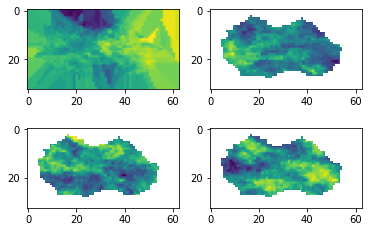

In [15]:
# what if we do layer means first?
# now try clustering the soilgrids data
cluster_input = np.empty(sg_raster.shape+(4,7), 'd')

fig = plt.figure()

# bulk density
for j in range(7):
    profile, raster = workflow.get_raster_on_shape(sg, watershed, crs, crs, mask=True, 
                                                nodata=-1, variable='BLDFIE', layer=j+1)
    print(profile['nodata'], raster.min(), raster.max())
    profile['nodata'] = raster.min()
    cluster_input[:,:,0,j] = np.where(raster == profile['nodata'], np.nan, raster)
    cluster_input[:,:,0,j] = workflow.condition.fill_gaps(cluster_input[:,:,0,j])
    cluster_input[:,:,0,j] = np.where(cluster_input[:,:,0,j] == -1, np.nan, cluster_input[:,:,0,j])

    # texture
    for i, varname in enumerate(['CLYPPT', 'SLTPPT', 'SNDPPT']):
        profile, raster = workflow.get_raster_on_shape(sg, watershed, crs, crs, mask=True, 
                                                   nodata=254, variable=varname, layer=j+1)
        print(profile['nodata'])
        assert(profile['nodata'] == 255)
        cluster_input[:,:,i+1,j] = np.where(raster == profile['nodata'], np.nan, raster)
        cluster_input[:,:,i+1,j] = workflow.condition.fill_gaps(cluster_input[:,:,i+1,j])
        cluster_input[:,:,i+1,j] = np.where(cluster_input[:,:,i+1,j] == 254, np.nan, cluster_input[:,:,i+1,j])

cluster_input = cluster_input.mean(axis=3)

for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(cluster_input[:,:,i])





In [ ]:
# do the clustering
for i in range(10):
    plt.figure()
    codebook, codes, err = workflow.soil_properties.cluster(cluster_input, i+1)
    print(err[0])
    plt.imshow(codes)

    

### SSURGO

The NRCS's SSURGO/STATSGO products provide shape-based information about the top 2m of soil.  This data is provided by formation, and includes multiple formations (map-units), in which each map unit has (potentially) multiple components and each component has (potentially) multiple horizons.  Short of taking the most prevelant component, we must average, so we tend to average horizons and components and just apply this uniformly in the top 2m.  Provided include a complete set of parameters:

* porosity
* permeability
* bulk density
* texture
* and more...

Unfortunately, while map units seem to cover the area of interest, they don't all have at least one horizon with valid data, so some formations end up with NaN values.  So while SSURGO can be used as an "overlay" with good soil layer information, it cannot be used alone without a gap-filling plan.

In [ ]:
# ssurgo
ss = FileManagerNRCS()
ss_crs, ss_shps, ss_props = workflow.get_shapes(ss, watershed.bounds, crs, crs, properties=True)



In [ ]:
# porosity
poro = np.array([ss_props[ss_props['mukey']==shp.properties['mukey']]['porosity [-]'] for shp in ss_shps])[:,0]
print(poro)

In [ ]:
# plot ssurgo porosity, note white inside the domain is NaN values
fig, ax = workflow.plot.get_ax(crs)

cb = workflow.plot.shplys(ss_shps, crs, poro, ax, facecolor='color')
#workflow.plot.shplys(ss_shps, crs, 'r', ax)
workflow.plot.shply(shp, crs, 'k', ax)
fig.colorbar(cb)
ax.relim()


## A combined, complete product?

Based on the above, it seems that the following are all viable strategies:

### GLHYMPS formations, porosity, and permeability, SoilGrids-based WRMs: 2 layer model

Use GLHYMPS for the data it provides, and fill in WRMs from Rosetta from SoilGrids texture data.  Average layer 7 over all pixels in the formation (GLHYMPS is also averaged across formation) to get a formation-homogeneous set of parameters.  The result is a two-layer model (bedrock and geology).

This is probably the simplest choice.

### GLHYMPS formations, SoilGrids data: 2 layer model

Same as above, but instead of using GLHYMPS porosity and permeability, use Rosetta's version of these same quantities.  Note that gap-filling the SoilGrids data is not necessary as long as averages across formations correctly deal with missing data.  

While Rosetta may be fairly uncertain in permeability, at least we have a consistent set of properties instead of using different sources for different fields.  It is complete (includes all data needed at all locations) and done by region/formation, and is fairly simple.

The main question between this one and the GLHYMPS data-based one is whether GLHYMPS "average value above continuous bedrock" is a better product that includes deeper information than SoilGrids does.

### GLHYMPS formations, SoilGrids data: 8 layers.

Use the GLHYMPS shapes, then average SoilGrids data across those shapes for each layer, and run Rosetta to get the full set of fields.  Use layer 7 below the bottom-most layer (2m to bedrock).  Bedrock is used below the SoilGrids depth-to-bedrock layer.  Note that gap-filling the SoilGrids data is not necessary as long as averages across formations correctly deal with missing data.

The one uncertainty is based on the vertical structure of 7 layers in SoilGrids -- assuming these are nodal values, we have to either interpolate or come up with a "horizon" for each layer.  This would result in 6 soil layers, a geologic layer (the 2m values) and a bedrock layer.

This is the same as the first, but with a more complex layering strategy.

### GLHYMPS + SSURGO formations

Do any of the above strategies, then overwrite whereever you have SSURGO data in the top 2m with SSURGO formations and properties.

In [ ]:
import os
print(os.environ['PROJ_NETWORK'])